In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from models.bilevels import BilevelAutoEncoder

from torch.utils.data import TensorDataset
import numpy as np

%matplotlib inline

device=torch.device("cpu")
torch.random.manual_seed(1)

In [3]:
Dz = 2
Dx = 2
Dh = 100
lr = 1e-4 # use a larger rate for demonstration

init_sigma = 0.1

torch.random.manual_seed(0)  
model = BilevelAutoEncoder(Dz, Dh, Dx, init_sigma, update_step_size=0.01)
dec_opt = torch.optim.Adam(model.parameters(), lr)

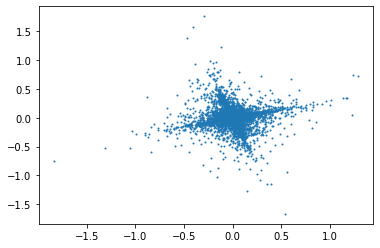

In [4]:
from ToyDatasets import SparseData, Mixture
sparse = SparseData()
torch.random.manual_seed(0)
test_x = sparse.sample(5000)
plt.scatter(*test_x.T, s=1)

In [5]:
bs = 1000
K = 0
M = 10

for i in tqdm.tqdm(range(0, 50)):

    dataset = TensorDataset(sparse.sample(100000), torch.ones(100000))
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=1)

    for idx, (images, _) in enumerate(tqdm.tqdm(data_loader, leave=False)):

        model.zero_encoder_grad()

        images = torch.as_tensor(images)

        #####  VAE  #####
        clean_x = images.view(bs, -1).to(device)
        x = clean_x

        for i in range(M):
            model.kl_encoder(x, reparam=False, bilevel=False)

        model.zero_encoder_grad()

        for i in range(K):
            model.kl_encoder(x, reparam=False, bilevel=True)

        dec_opt.zero_grad()

        # ELBO
#             loss = -model.ELBO(x)
        # M1
        loss = model.joint_score_x(x)

        # M2
        # loss = model.marginal_score(x)

        # M3
        # loss = model.bad_marginal_score(x)

        loss.backward()
        dec_opt.step()


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.0786, grad_fn=<ExpBackward>)


<Figure size 432x288 with 0 Axes>

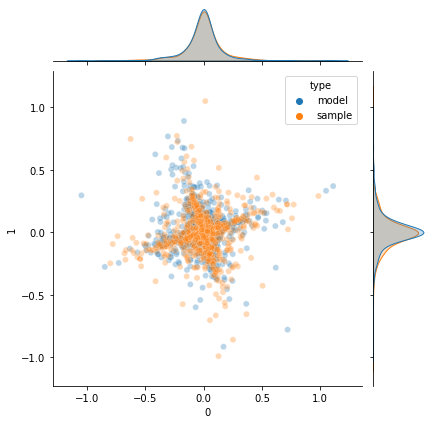

In [6]:
## helper to conver tensor to concatenated images
import seaborn as sns
import pandas as pd

model.eval()
print(model.logsigma.exp())

z = model.prior.sample([1000])


x = model.decode(z).mean.detach().numpy()
z = z.detach().numpy()
plt.figure()
sample = sparse.sample(1000).numpy()

x_df = pd.DataFrame(x)
x_df['type'] = 'model'

s_df = pd.DataFrame(sample)
s_df['type'] = 'sample'

df = pd.concat([x_df, s_df], axis=0)

sns.jointplot(data=df, x = 0, y = 1, hue='type', alpha=0.3)

In [7]:
model.log_likelihood(torch.as_tensor(test_x),nsample=10000).mean()

100%|██████████| 10/10 [00:00<00:00, 16.85it/s]


tensor(0.9719)

In [8]:
model.FD(test_x, nsample=10000).mean()

100%|██████████| 10/10 [00:00<00:00, 12.03it/s]


tensor(-83.1930)